In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin
import pandas as pd
import os

## Figure 1.
Make a two panel plot of HUXt solutions, one with boundary conditions from MAS and one with boundary conditions from WSA.

In [2]:
def plot_huxt_multi(ax, time, model):
    """
    Plot the HUXt solution at a specified time, and (optionally) overlay the modelled flank location and field of view
    of a specified observer.
    :param ax: Axes handle to plot in.
    :param time: The time to plot. The closest value in model.time_out is selected.
    :param model: A HUXt instance with the solution in.
    :return:
    """
    id_t = np.argmin(np.abs(model.time_out - time))

    # Get plotting data
    lon_arr, dlon, nlon = H.longitude_grid()
    lon, rad = np.meshgrid(lon_arr.value, model.r.value)
    mymap = mpl.cm.viridis
    v_sub = model.v_grid.value[id_t, :, :].copy()
    # Insert into full array
    if lon_arr.size != model.lon.size:
        v = np.zeros((model.nr, nlon)) * np.NaN
        if model.lon.size != 1:
            for i, lo in enumerate(model.lon):
                id_match = np.argwhere(lon_arr == lo)[0][0]
                v[:, id_match] = v_sub[:, i]
        else:
            print('Warning: Trying to contour single radial solution will fail.')
    else:
        v = v_sub

    # Pad out to fill the full 2pi of contouring
    pad = lon[:, 0].reshape((lon.shape[0], 1)) + model.twopi
    lon = np.concatenate((lon, pad), axis=1)
    pad = rad[:, 0].reshape((rad.shape[0], 1))
    rad = np.concatenate((rad, pad), axis=1)
    pad = v[:, 0].reshape((v.shape[0], 1))
    v = np.concatenate((v, pad), axis=1)

    mymap.set_over('lightgrey')
    mymap.set_under([0, 0, 0])
    levels = np.arange(200, 800 + 10, 10)
    cnt = ax.contourf(lon, rad, v, levels=levels, cmap=mymap, extend='both')
    # Remove edgelines that appear in pdfs
    for c in cnt.collections:
        c.set_edgecolor("face")

    cme_colors = ['r', 'c', 'm', 'y', 'deeppink', 'darkorange']
    for j, cme in enumerate(model.cmes):
        cid = np.mod(j, len(cme_colors))
        cme_lons = cme.coords[id_t]['lon']
        cme_r = cme.coords[id_t]['r'].to(u.solRad)
        if np.any(np.isfinite(cme_r)):
            # Pad out to close the profile.
            cme_lons = np.append(cme_lons, cme_lons[0])
            cme_r = np.append(cme_r, cme_r[0])
            ax.plot(cme_lons, cme_r, '-', color=cme_colors[cid], linewidth=3)

    planet_list = ['MERCURY', 'VENUS', 'EARTH', 'MARS', 'JUPITER', 'SATURN']
    planet_cols = ['black', 'tan', 'c', 'r', 'orange', 'm']
    # Add other planets if in model domain
    for planet, color in zip(planet_list, planet_cols ):
        obs = model.get_observer(planet)
        deltalon = 0.0*u.rad
        if model.frame == 'sidereal':
            earth_pos = model.get_observer('EARTH')
            deltalon = earth_pos.lon_hae[id_t] - earth_pos.lon_hae[0] 
        obslon = H._zerototwopi_(obs.lon[id_t] + deltalon)
        

        if planet == 'EARTH':
            ax.plot(obslon, obs.r[id_t], 'o', color=color, markersize=12, label=planet)
        elif (obs.r[id_t] > model.r.min()) & (obs.r[id_t] < model.r.max()):
            ax.plot(obslon, obs.r[id_t], 'o', color=color, markersize=12, label=planet)

    ax.set_ylim(0, model.r.value.max())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.patch.set_facecolor('slategrey')
    return


Files already exist for CR2254


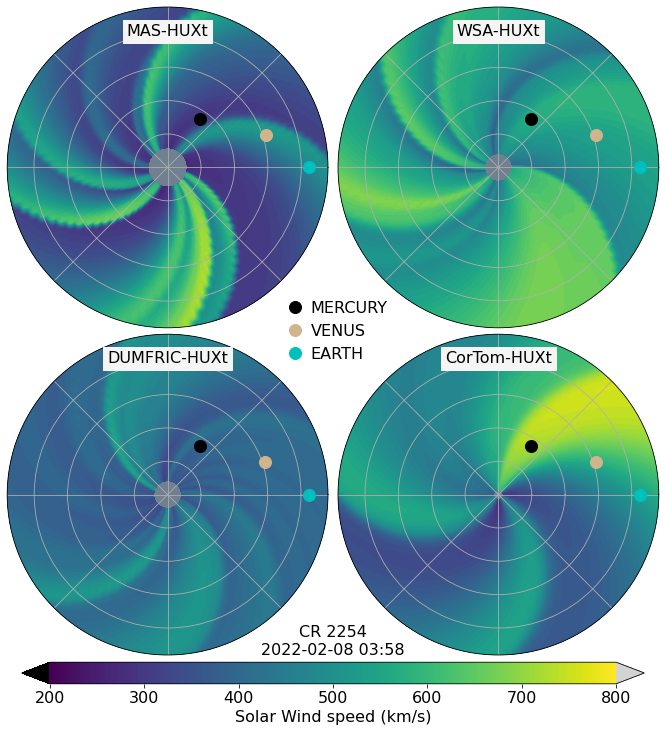

In [3]:
dirs = H._setup_dirs_()

demo_dir = H._setup_dirs_()['example_inputs']
wsafilepath = os.path.join(demo_dir, '2022-02-24T22Z.wsa.gong.fits')
cortomfilepath = os.path.join(demo_dir, 'tomo_8.00_20220224_tomo.txt')
dumfricfilepath = os.path.join(demo_dir, 'windbound_b20220224.12.nc')

vr_wsa = Hin.get_WSA_long_profile(wsafilepath, lat=0.0 * u.deg)
vr_cortom = Hin.get_CorTom_long_profile(cortomfilepath, lat=0.0 * u.deg)
vr_mas = Hin.get_MAS_long_profile(2254, lat=0.0 * u.deg)
vr_dumfric = Hin.get_PFSS_long_profile(dumfricfilepath, lat=0.0 * u.deg)

fig, ax = plt.subplots(2,2, figsize=(10,10), subplot_kw={"projection": "polar"})
id_time = 0
axr = ax.ravel()

for a, vr, r_min in zip(axr, [vr_mas, vr_wsa, vr_dumfric, vr_cortom], [30, 21.5, 21.5, 8]):

    model = H.HUXt(v_boundary=vr, cr_num=2254, r_min=r_min*u.solRad, simtime=1*u.day, dt_scale=4, frame = 'sidereal')
    model.solve([])
    plot_huxt_multi(a, model.time_out[id_time], model)

fig.subplots_adjust(left=0.00, bottom=0.10, right=1.0, top=1.0, wspace=-0.15, hspace=0.02)

mymap = mpl.cm.viridis
mymap.set_over('lightgrey')
mymap.set_under([0, 0, 0])
norm = mpl.colors.Normalize(vmin=200,vmax=800)
smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

posbl = ax[1,0].get_position()
posbr = ax[1,1].get_position()

dw = 0.02
dh = 0.04
left = posbl.x0 + dw
bottom = posbl.y0 - dh
width = (posbr.x0 + posbr.width) - posbl.x0 - 2*dw
height = 0.03
cbaxes = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(smp, cax=cbaxes, orientation='horizontal', extend='both')

cbar.set_label('Solar Wind speed (km/s)')

axr[0].text(0.5, 0.925,'MAS-HUXt', fontsize=16, backgroundcolor='whitesmoke', ha='center', va='center', transform=axr[0].transAxes)
axr[1].text(0.5, 0.925,'WSA-HUXt', fontsize=16, backgroundcolor='whitesmoke', ha='center', va='center', transform=axr[1].transAxes)
axr[2].text(0.5, 0.925,'DUMFRIC-HUXt', fontsize=16, backgroundcolor='whitesmoke', ha='center', va='center', transform=axr[2].transAxes)
axr[3].text(0.5, 0.925,'CorTom-HUXt', fontsize=16, backgroundcolor='whitesmoke', ha='center', va='center', transform=axr[3].transAxes)

fig.text(0.5, posbl.y0 + 0.025,'CR 2254', ha='center', fontsize=16)
label = (model.time_init + model.time_out[id_time]).strftime('%Y-%m-%d %H:%M')
fig.text(0.5, posbl.y0, label, ha='center', fontsize=16)

axr[0].legend(bbox_to_anchor=(0.5, 0.55), loc="center", bbox_transform=fig.transFigure, frameon=False, handletextpad=0.0, columnspacing=0.0)

dirs = H._setup_dirs_()
fig_name = 'fig_MAS_WSA_DUMFRIC_CorTom_example'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".png")
fig.savefig(fig_path)

## Figure 2

Make a three panel plot showing the evolution of a cone CME through HUXt. Use average CME speed and width as the CME scenario, take these statistics from the HELCATS KINCAT catalogue.


In [4]:
def get_cme_scenario():
    """
    Function to build the average, fast, and extreme CME scenarios used in the modelling.
    These are built from the percentiles of CME speed and width distributions of the
    HELCATS GCS fits in WP3 KINCAT (https://www.helcats-fp7.eu/catalogues/wp3_kincat.html)
    """
    column_names = ['ID', 'pre_date', 'pre_time', 'last_date', 'last_time', 'carlon',
                    'stolon', 'stolat', 'tilt', 'ssprat', 'h_angle', 'speed',  'mass']
    data = pd.read_csv('KINCAT_WP3_V02.txt', names=column_names, skiprows=4, delim_whitespace=True)

    percentile = 0.5
    speed = data['speed'].quantile(percentile)
    width = 2*data['h_angle'].quantile(percentile)
    return speed, width

cme_speed, cme_width = get_cme_scenario()
print(cme_speed, cme_width)

495.0 37.4


Files already exist for CR2254
Adjusting CME HEEQ longitude for sidereal frame
{'hit': True, 'hit_id': 161, 't_arrive': <Time object: scale='utc' format='jd' value=2459648.7281693695>, 't_transit': <Quantity 3.86673249 d>, 'lon': <Quantity 0.0679158 rad>, 'r': <Quantity 213.53227951 solRad>, 'v': <Quantity 366.39816551 km / s>}


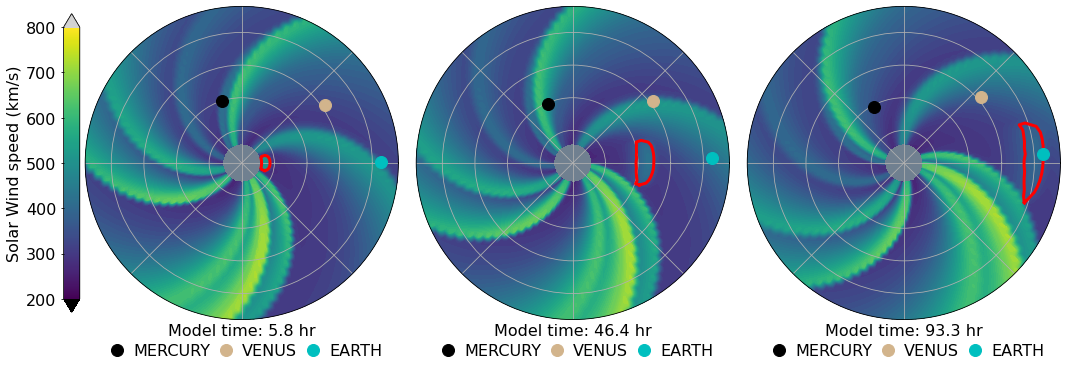

In [5]:
# Run HUXt with climatological average CME and plot at 3 timesteps - initiation, middle, and arrival at Earth
cme = H.ConeCME(t_launch=0.0*u.day, longitude=0.0*u.deg, width=cme_width*u.deg, v=cme_speed*(u.km/u.s), thickness=1*u.solRad)

vr_mas = Hin.get_MAS_long_profile(2254, lat=0.0 * u.deg)
#  Setup HUXt to do a 5 day simulation, with model output every 4 timesteps (roughly half and hour time step)
model = H.HUXt(v_boundary=vr_mas, cr_num=2254, cr_lon_init=15*u.deg, simtime=5*u.day, dt_scale=4, frame = 'sidereal')

model.solve([cme])

fig, ax = plt.subplots(1, 3, figsize=(15,5), subplot_kw={"projection": "polar"})

cme = model.cmes[0]
stats = cme.compute_arrival_at_body('Earth')
hit_id = stats['hit_id']
halfway_id = np.int(np.fix(hit_id/2.0))

for a, id_t in zip(ax, [10, halfway_id, hit_id]):

    plot_huxt_multi(a, model.time_out[id_t], model)

    label = "Model time: {:3.1f} hr".format(model.time_out[id_t].to(u.hr).value)
    a.text(0.5, -0.05,label, ha='center', fontsize=16, transform=a.transAxes)

fig.subplots_adjust(left=0.075, bottom=0.12, right=0.99, top=0.99, wspace=0.015)

mymap = mpl.cm.viridis
mymap.set_over('lightgrey')
mymap.set_under([0, 0, 0])
norm = mpl.colors.Normalize(vmin=200,vmax=800)
smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

pos = ax[0].get_position()
dw = 0.02
dh = 0.02
left = pos.x0 - dw
bottom = pos.y0 + dh
width = 0.015
height = pos.height - 2*dh
cbaxes = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')

cbaxes.yaxis.set_ticks_position('left')
cbaxes.yaxis.set_label_position('left')
cbar.set_label('Solar Wind speed (km/s)')

for a in ax:
    a.legend(bbox_to_anchor=(0.5, -0.1), loc="center", ncol=3, frameon=False, handletextpad=0.0, columnspacing=0.0)

dirs = H._setup_dirs_()
fig_name = 'fig_cone_cme_example'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".png")
fig.savefig(fig_path)
print(stats)

## Figure 3

Make three panel plot showing the impact of lowering the inner boundary of HUXt on resulting solar wind speed solutions.

In [6]:
# Setup HUXt for a standard 30Rs run
cr = 2254
vr_in = Hin.get_MAS_long_profile(cr,0.0*u.deg)
#now run HUXt
model30 = H.HUXt(v_boundary=vr_in, cr_num=cr, latitude=0*u.deg,
               simtime=27*u.day, dt_scale=4, frame = 'sidereal')
model30.solve([])

#  Map the inner boundary MAS values inwards from 30 rS to 10 rS
vr_10rs = Hin.map_v_boundary_inwards(vr_in, 30*u.solRad, 10*u.solRad)

#  Now setup HUXt to run from 10Rs
model10 = H.HUXt(v_boundary=vr_10rs, cr_num=cr, simtime=27*u.day,
               latitude=0*u.deg, dt_scale=4, r_min=10*u.solRad, frame = 'sidereal')
model10.solve([])



Files already exist for CR2254


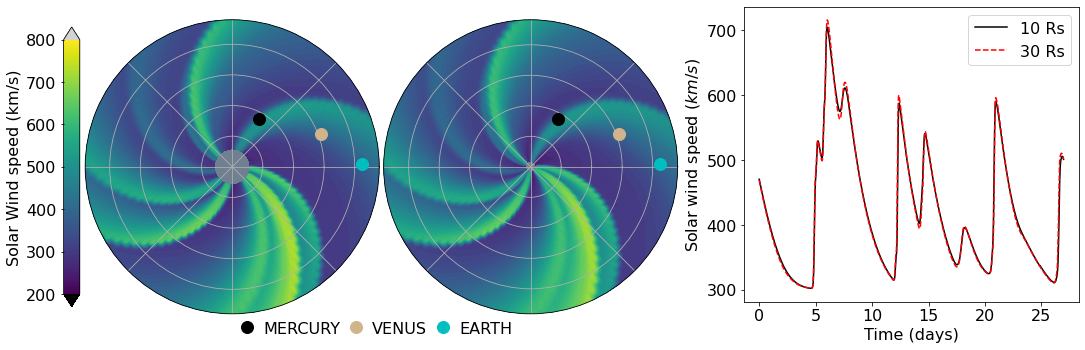

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
ax1 = plt.subplot(131, projection='polar')
ax2 = plt.subplot(132, projection='polar')
ax3 = plt.subplot(133)

id_t = 50
for a, m in zip([ax1, ax2], [model30, model10]):
    plot_huxt_multi(a, m.time_out[id_t], m)

ts10 = HA.get_earth_timeseries(model10)
ts30 = HA.get_earth_timeseries(model30)

t10 = (ts10['time'] - ts10['time'][0]).dt.total_seconds()/86400
t30 = (ts30['time'] - ts30['time'][0]).dt.total_seconds()/86400

ax3.plot(t10, ts10['vsw'], 'k-', label='10 Rs', zorder=1)
ax3.plot(t30, ts30['vsw'], 'r--', label='30 Rs', zorder=2)
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Solar wind speed ($km/s$)')
ax3.legend()
#ax3.xaxis.set_major_formatter(mpl.dates.DateFormatter('%m-%d'))

fig.subplots_adjust(left=0.075, bottom=0.02, right=0.9, top=0.99, wspace=0.015)

pos = [0.685, 0.13, 0.31, 0.82]
ax3.set_position(pos, which='both')

mymap = mpl.cm.viridis
mymap.set_over('lightgrey')
mymap.set_under([0, 0, 0])
norm = mpl.colors.Normalize(vmin=200,vmax=800)
smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

pos = ax1.get_position()
dw = 0.02
dh = 0.02
left = pos.x0 - dw
bottom = pos.y0 + dh
width = 0.015
height = pos.height - 2*dh
cbaxes = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')

cbaxes.yaxis.set_ticks_position('left')
cbaxes.yaxis.set_label_position('left')
cbar.set_label('Solar Wind speed (km/s)')

ax1.legend(bbox_to_anchor=(0.975, -0.05), loc="center", ncol=3, frameon=False, handletextpad=0.0, columnspacing=0.0)

dirs = H._setup_dirs_()
fig_name = 'fig_backmap_example'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name+".png")
fig.savefig(fig_path)

## Figure 4

An example of driving HUXt with in-situ solar wind data from OMNI

Files Downloaded: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.33file/s]


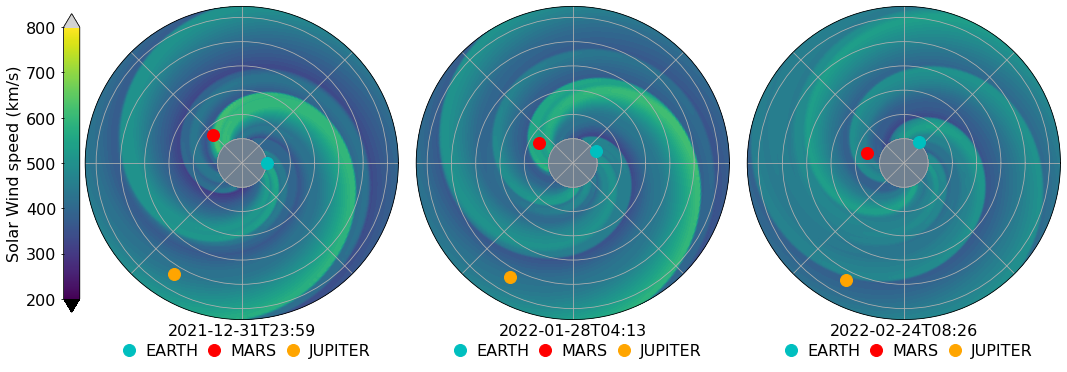

In [8]:
runstart = datetime.datetime(2022, 1, 1)
runend = datetime.datetime(2022, 4, 1)
simtime = (runend-runstart).days * u.day

#download and process the OMNI data
time, vcarr = Hin.generate_vCarr_from_OMNI(runstart, runend)

#set up the model
model = Hin.set_time_dependent_boundary(vcarr, time, runstart, simtime,
                                        r_min=215*u.solRad, r_max=1290*u.solRad,
                                           dt_scale=50, latitude=0*u.deg, frame = 'sidereal')

model.solve([]) #can take a couple of minutes to process the input data and solve the model out to Jupiter for 3 months

time_out = model.time_init + model.time_out

fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={"projection": "polar"})
for a, id_t in zip(ax, [0, 90, 180]):
    plot_huxt_multi(a, model.time_out[id_t], model)
    a.text(0.5, -0.05, time_out[id_t].strftime("%Y-%m-%dT%H:%M"), ha='center', fontsize=16, transform=a.transAxes)

fig.subplots_adjust(left=0.075, bottom=0.12, right=0.99, top=0.99, wspace=0.015)

# Add legends
for a in ax:
    a.legend(bbox_to_anchor=(0.5, -0.1), loc="center", ncol=3, frameon=False, handletextpad=0.0, columnspacing=0.0)

# Add colorbar
mymap = mpl.cm.viridis
mymap.set_over('lightgrey')
mymap.set_under([0, 0, 0])
norm = mpl.colors.Normalize(vmin=200,vmax=800)
smp = mpl.cm.ScalarMappable(norm=norm, cmap=mymap)

pos = ax[0].get_position()
dw = 0.02
dh = 0.02
left = pos.x0 - dw
bottom = pos.y0 + dh
width = 0.015
height = pos.height - 2*dh
cbaxes = fig.add_axes([left, bottom, width, height])
cbar = fig.colorbar(smp, cax=cbaxes, orientation='vertical', extend='both')

cbaxes.yaxis.set_ticks_position('left')
cbaxes.yaxis.set_label_position('left')
cbar.set_label('Solar Wind speed (km/s)')

dirs = H._setup_dirs_()
fig_name = 'fig_omni_boundary_example'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".png")
fig.savefig(fig_path)

## Figure 5

An example of tracing streamlines in HUXt

Files already exist for CR2254
Adjusting CME HEEQ longitude for sidereal frame


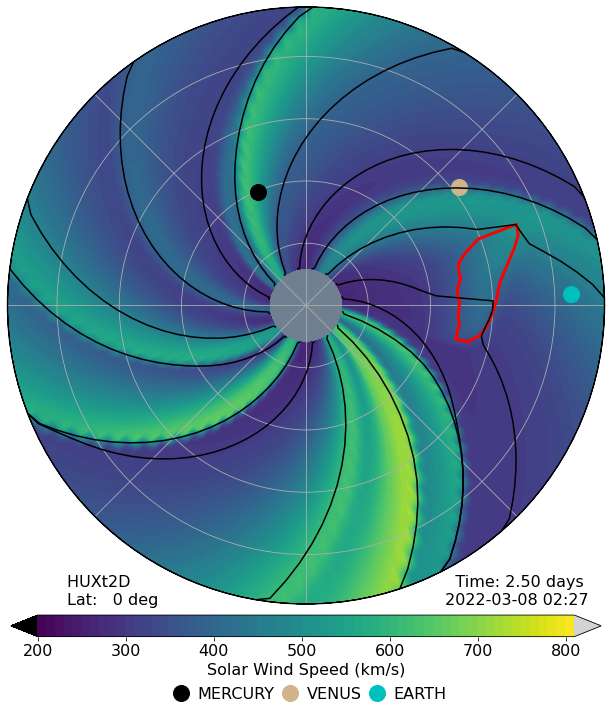

In [9]:
cr = 2254
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init = 25*u.deg, simtime=3*u.day, dt_scale=1, frame='sidereal', enable_field_tracer = True)

cme = H.ConeCME(t_launch=0.0*u.day, longitude=5.0*u.deg, width=cme_width*u.deg, v=cme_speed*(u.km/u.s), thickness=1*u.solRad)

#solve
model.solve([cme])

#trace a bunch of field lines from a range of evenly spaced Carrington longitudes
lon_grid = np.deg2rad(np.arange(0, 360, 22.5))*u.rad
streak_lines = []
for i in range(lon_grid.size):
    r, l = HA.huxt_streakline(model, lon_grid[i])
    streak_lines.append((r,l))

#plot these streamlines
time = 2.5*u.day
fig, ax = HA.plot(model,time, streaklines=streak_lines)

dirs = H._setup_dirs_()
fig_name = 'fig_streakline_example'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".png")
fig.savefig(fig_path)

## Figure 6

Tracking magnetic field polarity.

Files already exist for CR2254
Adjusting CME HEEQ longitude for sidereal frame
Files already exist for CR2254


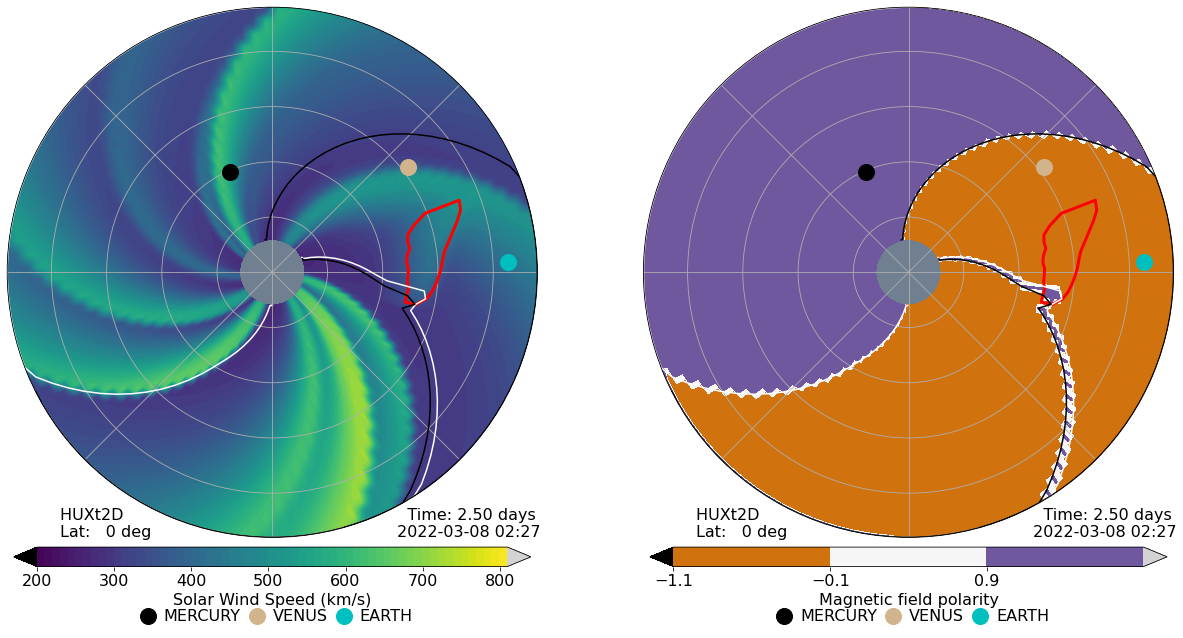

In [10]:
cr = 2254
vr_in = Hin.get_MAS_long_profile(cr, 0.0*u.deg)
model = H.HUXt(v_boundary=vr_in, cr_num=cr, cr_lon_init = 25*u.deg, simtime=3*u.day, dt_scale=1, frame='sidereal', enable_field_tracer=True)

cme = H.ConeCME(t_launch=0.0*u.day, longitude=5.0*u.deg, width=37.4*u.deg, v=495*(u.km/u.s), thickness=1*u.solRad)

#solve
model.solve([cme])

#get the Br values from the HelioMAS solution
br_in = Hin.get_MAS_br_long_profile(model.cr_num, 0.0*u.deg)

#compute the HCS streaklines and the b_grid
HA.add_bgrid(model, br_in)

fig, ax = plt.subplots(1, 2, figsize=(18, 9), subplot_kw={"projection": "polar"})

#plot the speed solution, including the HCS
time = 2.5*u.day

#plot the b-polarity grid
HA.plot(model, time, fighandle=fig, axhandle=ax[0], plotHCS=True)
HA.plot_bpol(model, time, fighandle=fig, axhandle=ax[1])

dirs = H._setup_dirs_()
fig_name = 'fig_polarity_map'
fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".pdf")
fig.savefig(fig_path)
fig_path = os.path.join(dirs['HUXt_figures'], fig_name + ".png")
fig.savefig(fig_path)